# Covid no Estado do Ceará

In [1]:
# importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
from folium import plugins
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import datetime as dt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

* Data from covid: https://brasil.io/home/
* Data of the cities: https://github.com/kelvins/Municipios-Brasileiros

In [2]:
data_covid = pd.read_csv('data/covid19.csv', parse_dates=True)
cities_lat_long = pd.read_csv('data/municipios.csv', parse_dates=True)
data_covid['date'] = pd.to_datetime(data_covid['date']).dt.strftime("%Y-%m-%d")
data_covid['city'].replace('Itapajé', 'Itapagé', inplace = True)

In [3]:
cities_lat_long.head(2)

codigo_ibge                 nome  latitude  longitude  capital  codigo_uf
0      5200050      Abadia de Goiás  -16.7573   -49.4412        0         52
1      3100104  Abadia dos Dourados  -18.4831   -47.3916        0         31

In [4]:
data_covid.head(2)

epidemiological_week        date  order_for_place state     city  \
0                    24  2020-06-12               47    CE  Abaiara   
1                    24  2020-06-12               56    CE  Acarape   

   city_ibge_code place_type  last_available_confirmed  \
0       2300101.0       city                         7   
1       2300150.0       city                       190   

   last_available_confirmed_per_100k_inhabitants  new_confirmed  \
0                                       59.64045              0   
1                                     1272.69074              1   

   last_available_deaths  new_deaths  last_available_death_rate  \
0                      1           0                     0.1429   
1                      9           1                     0.0474   

   estimated_population_2019  is_last  is_repeated  
0                    11737.0     True        False  
1                    14929.0     True        False

In [5]:
data = data_covid.merge(cities_lat_long,
                        how = 'inner',
                        left_on='city_ibge_code', 
                        right_on='codigo_ibge')
data.columns

Index(['epidemiological_week', 'date', 'order_for_place', 'state', 'city',
       'city_ibge_code', 'place_type', 'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'new_confirmed',
       'last_available_deaths', 'new_deaths', 'last_available_death_rate',
       'estimated_population_2019', 'is_last', 'is_repeated', 'codigo_ibge',
       'nome', 'latitude', 'longitude', 'capital', 'codigo_uf'],
      dtype='object')

In [6]:
data.drop(['order_for_place', 'place_type', 'is_repeated', 'codigo_ibge', 'nome'], axis = 1, inplace=True)

In [7]:
data.columns

Index(['epidemiological_week', 'date', 'state', 'city', 'city_ibge_code',
       'last_available_confirmed',
       'last_available_confirmed_per_100k_inhabitants', 'new_confirmed',
       'last_available_deaths', 'new_deaths', 'last_available_death_rate',
       'estimated_population_2019', 'is_last', 'latitude', 'longitude',
       'capital', 'codigo_uf'],
      dtype='object')

Abaixo eu crio um DataFrame com o código do IBGE e a respectiva cidade, e em seguida eu junto com os dados anteriores.
Fiz isso porque ao tentar plotar as informações o gráfico ficava todo preto, porque por algum motivo o Código do IGE do arquivo Json e do DataFrame fornecido pelo brasil.io não eram iguais. 

No arquivo Json o Código do IBGE é uma string, e por mais que eu convertesse os valores do DataFrame pra string ainda assim aparentemente eles não eram iguais(mesmo eu claramente vendo que eram iguais). Comprovei isso ao tentar fazer inner join nos dois datasets pelo Código do IBGE e o retorno era um DataFrame vazio. Quando tentei fazer o mesmo com as cidades o resultado funcionou.

Então decidi fazer inner join com os nomes das cidades e excluir a coluna do Código do IBGE do DataFrame inicial, e a partir de então utilizar o Código do IBGE que extraí do arquivo Json, que funcionou.

Outros pontos que foram corrigidos:
* O município do Itapagé está escrito como 'Itapajé' no data set do brasil.io ;
* O município do granjeiro não tem casos confirmados, entao no dataset que peguei do Brasil IO não cosnta as informações da Cidade;

In [8]:
import json

ce_cities = json.load(open('data/geojs-23-mun.json'))

id_cidade = []
nome_cidade = []

for i in range(len(ce_cities['features'])):
    Id = ce_cities['features'][i]['properties']['id']
    id_cidade.append(Id)
    nome = ce_cities['features'][i]['properties']['name']
    nome_cidade.append(nome)

ce = pd.DataFrame({'ibge_code': id_cidade, 'city': nome_cidade})

In [9]:
data = data.merge(ce, how = 'outer').drop('city_ibge_code', axis = 1)

# Mapa Confirmados

* Geodata Ceará on: https://github.com/tbrugz/geodata-br

In [10]:
columns = ['ibge_code', 'city', 'latitude', 'longitude', 'last_available_deaths', 'last_available_death_rate',
           'last_available_confirmed','last_available_confirmed_per_100k_inhabitants']
current_data = data[data['is_last'].fillna(True)][columns].fillna(0)

In [11]:
ceara = folium.Map(width= '45%',
                   height = '100%',
                   tiles='Mapbox Bright',
                   location = [-5.15, -39.5],
                   zoom_control=False,
                   min_zoom=7, max_zoom=9,
                   min_lat=-2.15, max_lat=-8.15, 
                   min_lon=-37, max_lon=-42, 
                   max_bounds=True,
                   zoom_start = 7)

In [12]:
current_data['log_casos_confirmados'] = np.log(current_data['last_available_confirmed']+1)

folium.Choropleth(geo_data = ce_cities,
                  name = 'Log de Casos Confirmados',
                  data = current_data,
                  columns = ['ibge_code' ,'log_casos_confirmados'],
                  key_on = 'feature.properties.id', 
                  fill_color = 'YlOrRd',
                  fill_opacity = 0.6,
                  line_color = 'black',
                  line_opacity = 1,
                  line_weight=0.25,
                  legend_name = 'Log de casos confirmados',
                  show = True,
                 ).add_to(ceara)

In [13]:
for i in range(len(current_data)):
    folium.Circle(
        location=[current_data.iloc[i]['latitude'], current_data.iloc[i]['longitude']],
        color = 'gray',
        fill = 'gray',
        tooltip =
        '<meta http-equiv="content-type" content="text/html; charset=UTF-8" /><ul><li><bold>Cidade: </bold>'+ str(current_data.iloc[i]['city'])+'</li>'+
        '<li><bold>Casos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_confirmed'])+'</li>'+
        '<li><bold>Obitos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_deaths'])+'</li></ul>',
        radius = 1000
    ).add_to(ceara)

In [14]:
ceara

In [15]:
ceara_obitos = folium.Map(width = '45%',
                          height = '100%',
                          tiles = 'Mapbox Bright',
                          location = [-5.15, -39.5],
                          zoom_control = True,
                          min_zoom = 7,
                          max_zoom = 9,
                          min_lat = -2.15,
                          max_lat=-8.15,
                          min_lon=-37, max_lon=-42,
                          max_bounds=True,
                          zoom_start = 7)

In [16]:
current_data['log_obitos'] = np.log(current_data['last_available_deaths']+1)

folium.Choropleth(geo_data = ce_cities,
                  name = 'Obitos',
                  data = current_data,
                  columns = ['ibge_code' ,'log_obitos'],
                  key_on = 'feature.properties.id', 
                  fill_color = 'YlOrRd',
                  fill_opacity = 0.6,
                  line_color = 'black',
                  line_opacity = 1,
                  line_weight=0.25,
                  legend_name = 'Log de Obitos',
                  show = True,
                 ).add_to(ceara_obitos)

In [17]:
for i in range(len(current_data)):
    folium.Circle(
        location=[current_data.iloc[i]['latitude'], current_data.iloc[i]['longitude']],
        color = 'gray',
        fill = 'gray',
        tooltip =
        '<meta http-equiv="content-type" content="text/html; charset=UTF-8" /><ul><li><bold>Cidade: </bold>'+ str(current_data.iloc[i]['city'])+'</li>'+
        '<li><bold>Casos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_confirmed'])+'</li>'+
        '<li><bold>Obitos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_deaths'])+'</li></ul>',
        radius = 1000
    ).add_to(ceara_obitos)

In [18]:
ceara_obitos

In [19]:
attr = ('&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> '
        'contributors, &copy; <a href="http://cartodb.com/attributions">CartoDB</a>')
tiles = 'http://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'

ceara_heatmap = folium.Map(width = '55%',
                           height = '100%',
                           tiles=tiles,
                           attr = attr,
                           location = [-5.15, -39.5],
                           zoom_control = False,
                           min_zoom=7,
                           max_zoom=12,
                           min_lat=-2.15,
                           max_lat=-8.15,
                           min_lon=-37,
                           max_lon=-42,
                           max_bounds=True,
                           zoom_start = 7)

In [20]:
columns = ['latitude', 'longitude', 'last_available_confirmed']
ceara_heatmap = ceara_heatmap.add_child(plugins.HeatMap(current_data[columns]))

In [21]:
for i in range(len(current_data)):
    folium.Circle(
        location=[current_data.iloc[i]['latitude'], current_data.iloc[i]['longitude']],
        color = '#00D611',
        fill = '#3EE02A',
        tooltip =
        '<ul><li><bold>Cidade: </bold>'+ str(current_data.iloc[i]['city'])+'</li>'+
        '<li><bold>Casos Confirmados: </bold>'+ str(current_data.iloc[i]['last_available_confirmed'])+'</li></ul>',
        radius = 1000
    ).add_to(ceara_heatmap)

In [22]:
ceara_heatmap

In [23]:
ceara.save('maps/log_casos.html')
ceara.save('maps/log_obitos.html')
ceara_heatmap.save('maps/ceara_heatmap.html')

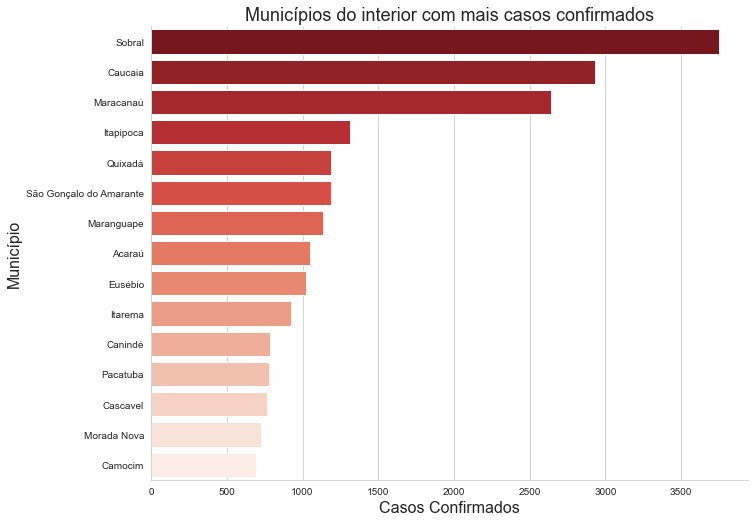

In [24]:
df = current_data.sort_values(by='last_available_confirmed', ascending = False)

sns.set_style("whitegrid")
g = sns.catplot(x = 'last_available_confirmed',
                y = 'city',
                data=df.iloc[1:16, [1,6]],
                kind = 'bar',
                palette="Reds_r",
                height=7,
                aspect=1.5)

g.ax.set_title("Municípios do interior com mais casos confirmados", fontdict = {'size':18})
g.ax.xaxis.set_label_text("Casos Confirmados", fontdict = {'size':16})
g.ax.yaxis.set_label_text("Município", fontdict = {'size':16})
g.savefig('images/casos_interior.png')
plt.show()

In [25]:
trace = go.Bar(x = df.iloc[1:21].sort_values(by = 'last_available_confirmed').last_available_confirmed,
               y = df.iloc[1:21].sort_values(by = 'last_available_confirmed').city,
               orientation='h',
               marker = dict(color = 'rgba(255, 51, 51, 0.9)',
                             line=dict(color='rgb(35, 32, 33)', width=1.5)),
               hoverinfo = 'x')

layout = {
    'title': 'Casos Confirmados em cidades do Interior',
    'yaxis': {'title': 'Cidades'},
    'xaxis': {'title': 'Número de casos confirmados'}
}
fig = go.Figure(data = trace, layout=layout)
fig.write_html('graphs/Cases_per_100k_hab.html')
iplot(fig)

In [26]:
data_covid.head()

epidemiological_week        date  order_for_place state      city  \
0                    24  2020-06-12               47    CE   Abaiara   
1                    24  2020-06-12               56    CE   Acarape   
2                    24  2020-06-12               57    CE    Acaraú   
3                    24  2020-06-12               61    CE  Acopiara   
4                    24  2020-06-12               40    CE    Aiuaba   

   city_ibge_code place_type  last_available_confirmed  \
0       2300101.0       city                         7   
1       2300150.0       city                       190   
2       2300200.0       city                      1047   
3       2300309.0       city                       156   
4       2300408.0       city                         7   

   last_available_confirmed_per_100k_inhabitants  new_confirmed  \
0                                       59.64045              0   
1                                     1272.69074              1   
2                                     1671.42926              4   
3                                      287.45163              0   
4                                       40.23220              0   

   last_available_deaths  new_deaths  last_available_death_rate  \
0                      1           0                     0.1429   
1                      9           1                     0.0474   
2                     28           0                     0.0267   
3                     10           0                     0.0641   
4                      0           0                     0.0000   

   estimated_population_2019  is_last  is_repeated  
0                    11737.0     True        False  
1                    14929.0     True        False  
2                    62641.0     True        False  
3                    54270.0     True        False  
4                    17399.0     True        False

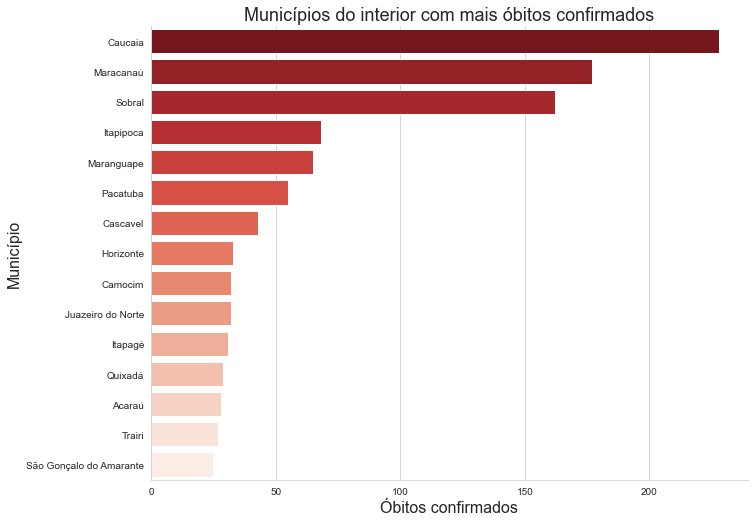

In [27]:
df = current_data.sort_values(by='last_available_deaths', ascending = False)

sns.set_style("whitegrid")
g = sns.catplot(x = 'last_available_deaths',
                y = 'city', data=df.iloc[1:16, [1,4]],
                kind = 'bar',
                palette="Reds_r",
                height=7,
                aspect=1.5)
g.ax.set_title("Municípios do interior com mais óbitos confirmados", fontdict = {'size':18})
g.ax.xaxis.set_label_text("Óbitos confirmados", fontdict = {'size':16})
g.ax.yaxis.set_label_text("Município", fontdict = {'size':16})
g.savefig('images/casos_interior.png')
plt.show()

In [28]:
trace = go.Bar(x = df.iloc[1:21].sort_values(by='last_available_deaths').last_available_deaths,
               y = df.iloc[1:21].sort_values(by='last_available_deaths').city,
               orientation='h',
               marker = dict(color = 'rgba(255, 51, 51, 0.9)',
                             line=dict(color='rgb(35, 32, 33)', width=1.5)),
               hoverinfo = 'x')

layout = {
    'title': 'Óbitos em cidades do interior',
    'yaxis': {'title': 'Cidades'},
    'xaxis': {'title': 'Número de óbitos'}
}
fig = go.Figure(data = trace, layout=layout)
fig.write_html('graphs/deaths.html')
iplot(fig)

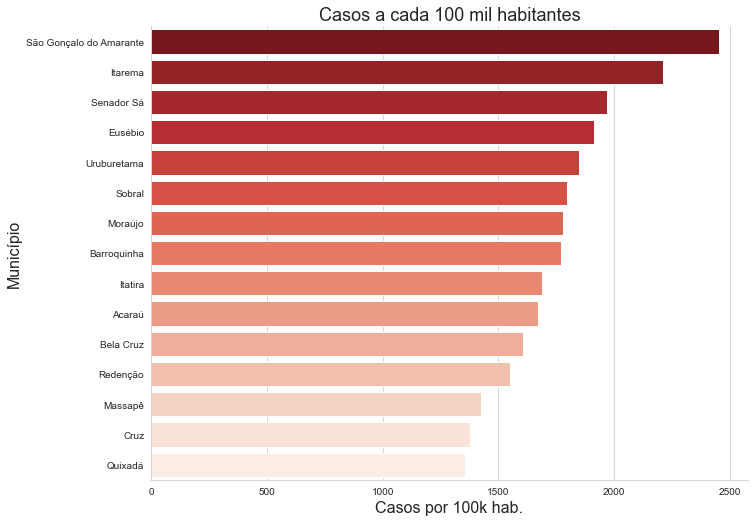

In [29]:
df = current_data.sort_values(by='last_available_confirmed_per_100k_inhabitants', ascending = False)

sns.set_style("whitegrid")
g = sns.catplot(x = 'last_available_confirmed_per_100k_inhabitants',
                y = 'city',
                data=df.iloc[0:15, [1,7]],
                kind = 'bar',
                palette="Reds_r",
                height=7,
                aspect=1.5)
g.ax.set_title("Casos a cada 100 mil habitantes", fontdict = {'size':18})
g.ax.xaxis.set_label_text("Casos por 100k hab.",fontdict = {'size':16})
g.ax.yaxis.set_label_text("Município",fontdict = {'size':16})
g.savefig('images/casos_interior.png')
plt.show()

In [30]:
trace = go.Bar(x = df.iloc[0:20].sort_values(by='last_available_confirmed_per_100k_inhabitants').last_available_confirmed_per_100k_inhabitants,
               y = df.iloc[0:20].sort_values(by='last_available_confirmed_per_100k_inhabitants').city,
               orientation='h',
               marker = dict(color = 'rgba(255, 51, 51, 0.9)',
                             line=dict(color='rgb(35, 32, 33)', width=1.5)),
               hoverinfo = 'x')

layout = {
    'title': 'Casos confirmados a cada 100 mil habitantes',
    'yaxis': {'title': 'Cidades'},
    'xaxis': {'title': 'Casos por 100mil hab.'}
}
fig = go.Figure(data = trace, layout=layout)

fig.write_html('graphs/Cases_per_100k_hab.html')
iplot(fig)

# Preparar Séries Temporais

In [31]:
data_covid.head(2)

epidemiological_week        date  order_for_place state     city  \
0                    24  2020-06-12               47    CE  Abaiara   
1                    24  2020-06-12               56    CE  Acarape   

   city_ibge_code place_type  last_available_confirmed  \
0       2300101.0       city                         7   
1       2300150.0       city                       190   

   last_available_confirmed_per_100k_inhabitants  new_confirmed  \
0                                       59.64045              0   
1                                     1272.69074              1   

   last_available_deaths  new_deaths  last_available_death_rate  \
0                      1           0                     0.1429   
1                      9           1                     0.0474   

   estimated_population_2019  is_last  is_repeated  
0                    11737.0     True        False  
1                    14929.0     True        False

In [32]:
ts_novos_casos = pd.pivot_table(index = 'city',
                                columns = 'date',
                                values = 'new_confirmed',
                                data = data_covid
                                ).fillna(0).astype('int')

ts_total_casos = pd.pivot_table(index = 'city',
                          columns = 'date',
                          values = 'last_available_confirmed',
                          data = data_covid
                         ).fillna(0).astype('int')

ts_novos_obitos = pd.pivot_table(index = 'city',
                                columns = 'date',
                                values = 'new_deaths',
                                data = data_covid
                                ).fillna(0).astype('int')

ts_total_obitos = pd.pivot_table(index = 'city',
                                 columns = 'date',
                                 values = 'last_available_deaths',
                                 data = data_covid
                                ).fillna(0).astype('int')

ts_ce = data_covid.loc[data_covid['city'].isna(),
                         ['date',
                          'new_confirmed',
                          'last_available_confirmed',
                          'new_deaths',
                          'last_available_deaths']].sort_values(by='date').set_index('date')

In [33]:
# Série Temporal - Ceará

In [34]:
ts_ce.tail()

new_confirmed  last_available_confirmed  new_deaths  \
date                                                              
2020-06-08           1947                     66218         210   
2020-06-09           2805                     69023         167   
2020-06-10           2924                     71947         160   
2020-06-11           2745                     74692         189   
2020-06-12           1092                     75784         104   

            last_available_deaths  
date                               
2020-06-08                   4192  
2020-06-09                   4359  
2020-06-10                   4519  
2020-06-11                   4708  
2020-06-12                   4812

In [35]:
trace = go.Bar(x=ts_ce.index,
               y = ts_ce.last_available_confirmed,
               name = 'Casos confirmados',
               marker = dict(color = 'rgba(0, 0, 255, 0.8)'))
               
layout = go.Layout(title = 'Série Temporal de casos confirmados no Ceará', barmode= 'relative')
fig = go.Figure(trace, layout=layout)
fig.write_html('graphs/ts_casos_ce.html')
fig.show()

In [36]:
trace= go.Bar(x=ts_ce.index,
                y = ts_ce.last_available_deaths,
                name = 'Óbitos confirmados',
                marker = dict(color = 'rgba(255, 0, 0, 0.8)'),
                 text = ts_ce.last_available_confirmed)

layout = go.Layout(title = 'Série Temporal de óbitos por COVID-19 no Ceará', barmode= 'relative')
fig = go.Figure(trace, layout=layout)
fig.write_html('graphs/ts_obitos_ce.html')
fig.show()

In [37]:
# Séries temporais fortaleza
ts_total_casos.sort_values(by='2020-06-10', ascending = False, inplace=True)
ts_total_obitos.sort_values(by='2020-06-10', ascending = False, inplace=True)

trace= go.Bar(x=ts_novos_casos.columns,
                y = ts_total_casos.loc['Fortaleza'],
                name = 'Casos Confirmados',
                marker = dict(color = 'rgba(0, 0, 255, 0.8)'))

layout = go.Layout(title = 'Série Temporal de casos confirmados em Fortaleza', barmode= 'relative')
fig = go.Figure(trace, layout=layout)
fig.write_html('graphs/ts_casos_fortal.html')
fig.show()

In [38]:
trace= go.Bar(x=ts_total_obitos.columns,
                y = ts_total_obitos.loc['Fortaleza'],
                name = 'Número de Óbitos',
                marker = dict(color = 'rgba(255, 0, 0, 0.8)'))

layout = go.Layout(title = 'Série Temporal de óbitos por COVID-19 em Fortaleza', barmode= 'relative')
fig = go.Figure(trace, layout=layout)
fig.write_html('graphs/ts_obitos_fortal.html')
fig.show()

In [39]:
# Curvas de cidades com mais casos


traces = []

for city in ts_total_casos.drop('Importados/Indefinidos').index[1:6]:
    trace = go.Scatter(x = ts_total_casos.columns,
                       y = ts_total_casos.loc[city],
                      name = city)
    traces.append(trace)
    
layout = go.Layout(title = 'Séries Temporais do municípios com mais casos confirmados')
fig = go.Figure(traces, layout=layout)
fig.write_html('graphs/ts_casos_interior.html')
fig.show()

In [40]:
# Curvas de cidades com mais casos


traces = []

for city in ts_total_casos.drop('Importados/Indefinidos').index[1:6]:
    trace = go.Scatter(x = ts_total_obitos.columns,
                       y = ts_total_obitos.loc[city],
                      name = city)
    traces.append(trace)
    
layout = go.Layout(title = 'Séries Temporais do municípios com maior número de óbitos')
fig = go.Figure(traces, layout=layout)
fig.write_html('graphs/ts_obitos_interior.html')
fig.show()